In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import datetime
from dateutil.parser import parse
from utils import mean_2d_diff_size

Read the logs of our implementation

In [2]:
LOGS_PATH = "../mil-2/logs/"
objs_in_path = listdir(LOGS_PATH)
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'json' in f]

In [3]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data = pd.concat(logs, axis=0, ignore_index=True)
for field in ['end_time', 'start-time', 'start-compute-time', 'end-compute-time']:
    data[field] = data[field].apply(parse)
data['compute-time'] = (data['end-compute-time'] - data['start-compute-time'])/np.timedelta64(1, 's')

In [4]:
LOGS_PATH = "../mil-2/logs-hogwild/"
objs_in_path = listdir(LOGS_PATH)
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f))and 'json' in f]

In [5]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data_hog = pd.concat(logs, axis=0, ignore_index=True)

Plot the running time vs number of workers for each implementation (i.e. asynchronous with and without lock)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


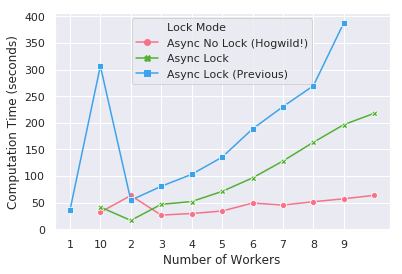

In [6]:
async_df = data[['lock', 'num_workers', 'compute-time']].groupby(['lock', 'num_workers']).median().reset_index()
async_df.lock[async_df.lock == True] = 'Async Lock'
async_df.lock[async_df.lock == False] = 'Async No Lock (Hogwild!)'

hog_df = data_hog[['n_workers', 'running_time']].groupby(['n_workers']).median().reset_index().rename(columns={'n_workers': 'num_workers', 'running_time': 'compute-time'})
hog_df['lock'] = 'Async Lock (Previous)'

async_df = pd.concat([async_df, hog_df], sort=False)

ax = sns.lineplot(x='num_workers', y='compute-time', hue='lock', style='lock', markers=True, dashes=False, palette=sns.color_palette("husl", 3), data=async_df)
ax.set_xlabel('Number of Workers')
ax.set_ylabel('Computation Time (seconds)')
legend = ax.legend()
legend.texts[0].set_text('Lock Mode');

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


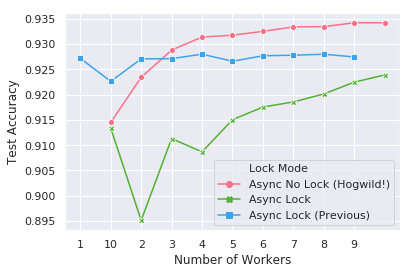

In [7]:
async_df = data[['lock', 'num_workers', 'test_accuracy']].groupby(['lock', 'num_workers']).median().reset_index()
async_df.lock[async_df.lock == True] = 'Async Lock'
async_df.lock[async_df.lock == False] = 'Async No Lock (Hogwild!)'

hog_df = data_hog[['n_workers', 'accuracy_test']].groupby(['n_workers']).median().reset_index().rename(columns={'n_workers': 'num_workers', 'accuracy_test': 'test_accuracy'})
hog_df['lock'] = 'Async Lock (Previous)'

async_df = pd.concat([async_df, hog_df], sort=False)

ax = sns.lineplot(x='num_workers', y='test_accuracy', hue='lock', style='lock', markers=True, dashes=False, palette=sns.color_palette("husl", 3), data=async_df)
ax.set_xlabel('Number of Workers')
ax.set_ylabel('Test Accuracy')
legend = ax.legend()
legend.texts[0].set_text('Lock Mode');

In [8]:
async_df = data[['lock', 'num_workers', 'compute-time', 'epochs-stats']].groupby(['lock', 'num_workers']).agg({'compute-time':'median', 'epochs-stats':'first'}).reset_index()
async_lock_df = async_df[async_df.lock == True]
async_no_lock_df = async_df[async_df.lock == False]

hog_df = data_hog[['n_workers', 'running_time', 'losses_val']].groupby(['n_workers']).agg({'running_time':'median', 'losses_val':'first'}).reset_index().rename(columns={'n_workers': 'num_workers', 'running_time': 'compute-time', 'losses_val': 'epochs-stats'})
hog_df['num_workers'] = pd.to_numeric(hog_df['num_workers'])

In [9]:
val_losses_lock = []
val_losses_no_lock = []
val_losses_hog = []
for w in range(1, 11):
    losses_lock = async_lock_df[async_lock_df.num_workers == w]['epochs-stats'].values[0]
    losses_no_lock = async_no_lock_df[async_no_lock_df.num_workers == w]['epochs-stats'].values[0]
    losses_hog = hog_df[hog_df.num_workers == w]['epochs-stats'].values[0]
    losses_w_lock = []
    losses_w_no_lock = []
    losses_w_hog = []
    for d in losses_lock:
        d['num_workers'] = w
        losses_w_lock += [d]
    val_losses_lock += losses_w_lock
    for d in losses_no_lock:
        d['num_workers'] = w
        losses_w_no_lock += [d]
    val_losses_no_lock += losses_w_no_lock
    for i, d in enumerate(losses_hog):
        d_ = {'val_loss': d['loss_val'],
              'num_workers': w,
              'epoch_number': i}
        losses_w_hog += [d_]
    val_losses_hog += losses_w_hog
    
loss_conv_lock_df = pd.DataFrame(val_losses_lock)
loss_conv_no_lock_df = pd.DataFrame(val_losses_no_lock)
loss_conv_hog_df = pd.DataFrame(val_losses_hog)

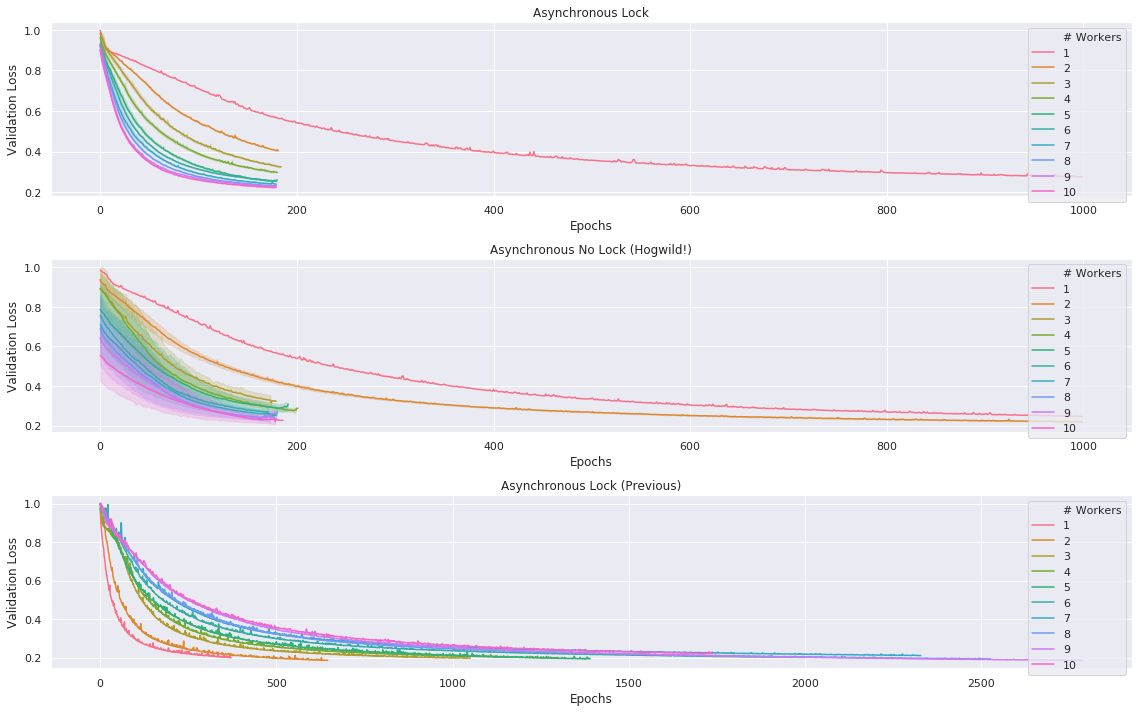

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))

axs[0] = sns.lineplot(x='epoch_number', y='val_loss', ax=axs[0], hue='num_workers', markers=True, dashes=False, palette=sns.color_palette("husl", 10), data=loss_conv_lock_df)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Validation Loss')
axs[0].set_title('Asynchronous Lock')

axs[1] = sns.lineplot(x='epoch_number', y='val_loss', ax=axs[1], hue='num_workers', markers=True, dashes=False, palette=sns.color_palette("husl", 10), data=loss_conv_no_lock_df)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Validation Loss');
axs[1].set_title('Asynchronous No Lock (Hogwild!)')
# TODO: Remove the next line
# plt.gca().set_xlim((0, 200));

axs[2] = sns.lineplot(x='epoch_number', y='val_loss', ax=axs[2], hue='num_workers', markers=True, dashes=False, palette=sns.color_palette("husl", 10), data=loss_conv_hog_df)
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Validation Loss');
axs[2].set_title('Asynchronous Lock (Previous)')

plt.tight_layout()
legend = axs[0].legend()
legend.texts[0].set_text('# Workers')
legend = axs[1].legend()
legend.texts[0].set_text('# Workers')
legend = axs[2].legend()
legend.texts[0].set_text('# Workers');